In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from random import randint
import sklearn.metrics as skm
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [2]:
def replace_rare_entries(df, columns, threshold_frac):
    tot_instances = df.shape[0]
    threshold = tot_instances * threshold_frac
    df = df.apply(lambda x: x.mask(x.map(x.value_counts()) < threshold, 'RARE') if x.name in columns else x)
    return df

In [53]:
categorical = ['OP_UNIQUE_CARRIER', 'DEST', 'DEP_TIME_BLK', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'MONTH']
continuous = ['ARR_DELAY_1', 'DEP_DELAY_2', 'ARR_DELAY_2', 'DEP_DELAY_3']#, ARR_DELAY_0', 'DEP_DELAY_1']
targets = ['DEP_DELAY_NEW', 'DEP_DEL15']

In [54]:
df = pd.read_csv('/home/dbeiski/Project/FlightDelay/Data/new_york/year_lga_dep_w_prev_flights.csv')

In [73]:
df.shape[0]

172073

In [55]:
data = df.loc[:, continuous + categorical]

In [56]:
# data[continuous] = (data[continuous] - data[continuous].mean()) / data[continuous].std()
data[continuous] = data[continuous].fillna(0)

In [57]:
data.head()

,ARR_DELAY_1,DEP_DELAY_2,ARR_DELAY_2,DEP_DELAY_3,OP_UNIQUE_CARRIER,DEST,DEP_TIME_BLK,DAY_OF_MONTH,DAY_OF_WEEK,MONTH
0,2.0,0.0,22.0,-1.0,UA,ORD,0001-0559,1,5,6
1,-2.0,-9.0,8.0,16.0,AA,MIA,0001-0559,1,5,6
2,4.0,10.0,2.0,-4.0,AA,DFW,0001-0559,1,5,6
3,0.0,0.0,0.0,0.0,WN,DAL,0600-0659,1,5,6
4,-21.0,-6.0,-10.0,-5.0,WN,HOU,0600-0659,1,5,6


In [58]:

data = replace_rare_entries(data, ['DEST'], 0.005)
data = replace_rare_entries(data, ['UNIQUE_CARRIER'], 0.005)
data = pd.get_dummies(data, columns=categorical)
label = df['DEP_DEL15']

In [59]:
data.columns

Index(['ARR_DELAY_1', 'DEP_DELAY_2', 'ARR_DELAY_2', 'DEP_DELAY_3',
       'OP_UNIQUE_CARRIER_9E', 'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_B6',
       'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
       ...
       'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8',
       'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'],
      dtype='object', length=139)

In [60]:
data = data[~label.isna()]
label = label[~label.isna()]

In [61]:
print('Rows: {}\nFeatures: {}\nLabel-1 Fraction: {}'
      .format(data.shape[0], data.shape[1], label.sum() / label.shape[0]))

Rows: 166735
Features: 139
Label-1 Fraction: 0.21788466728641256


In [62]:
thres = np.linspace(0, 1, 500)

In [63]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)

In [64]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=y)
Dtrain = xgb.DMatrix(x_train, label=y_train)
Dval = xgb.DMatrix(x_val, label=y_val)

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [65]:
y_train.shape[0]

106710

In [66]:
param = {                              # General guidelines for initial paramaters:
    'min_child_weight': 1,             # 1 (choose small for high class imbalance)
    'gamma': 0.3,                        # 0.1-0.2
    'lambda': 0,  #1                     # L2 Regulariztion - default = 1
    'scale_pos_weight': 4,             # 1 (choose small for high class imbalance)
    'subsample': 0.6,                    # 0.5-0.9
    'colsample_bytree': 0.8,             # 0.5-0.9
    'colsample_bylevel': 0.7,              # 0.5-0.9
    'max_depth': 6,  #5                  # 3-10 
    'eta': 0.1,                        # 0.05-0.3
    'silent': 0,                       # 0 - prints progress    1 - quiet
    'objective': 'binary:logistic',        
    'num_class': 1,             
    'eval_metric': 'auc'}  
num_round = 10000                                      # the number of training iterations if not stopped early
evallist = [(Dtrain, 'train'), (Dval, 'eval')]        # Specify validation set to watch performance

In [67]:
# Train the model on the training set to get an initial impression on the performance
model = xgb.train(param, Dtrain, num_round, evallist, early_stopping_rounds=10)
print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	train-auc:0.681593	eval-auc:0.673019
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.708966	eval-auc:0.695573
[2]	train-auc:0.713663	eval-auc:0.697831
[3]	train-auc:0.715432	eval-auc:0.700433
[4]	train-auc:0.721662	eval-auc:0.706891
[5]	train-auc:0.725506	eval-auc:0.708559
[6]	train-auc:0.727813	eval-auc:0.711633
[7]	train-auc:0.73108	eval-auc:0.714962
[8]	train-auc:0.732112	eval-auc:0.714979
[9]	train-auc:0.734006	eval-auc:0.716503
[10]	train-auc:0.736809	eval-auc:0.718603
[11]	train-auc:0.739628	eval-auc:0.721302
[12]	train-auc:0.740354	eval-auc:0.722582
[13]	train-auc:0.742697	eval-auc:0.724515
[14]	train-auc:0.744964	eval-auc:0.726651
[15]	train-auc:0.745485	eval-auc:0.727302
[16]	train-auc:0.748981	eval-auc:0.731131
[17]	train-auc:0.749677	eval-auc:0.731652
[18]	train-auc:0.750579	eval-auc:0.732278
[19]	train-auc:0.751846	eval-auc:0.733122
[20]	train-auc:0.753159	eval-a

[191]	train-auc:0.8424	eval-auc:0.793089
[192]	train-auc:0.842555	eval-auc:0.793081
[193]	train-auc:0.842752	eval-auc:0.793246
[194]	train-auc:0.84297	eval-auc:0.793264
[195]	train-auc:0.843215	eval-auc:0.79341
[196]	train-auc:0.843435	eval-auc:0.79341
[197]	train-auc:0.843579	eval-auc:0.793594
[198]	train-auc:0.843717	eval-auc:0.793635
[199]	train-auc:0.843946	eval-auc:0.793739
[200]	train-auc:0.844329	eval-auc:0.793734
[201]	train-auc:0.844625	eval-auc:0.793829
[202]	train-auc:0.844824	eval-auc:0.793814
[203]	train-auc:0.844939	eval-auc:0.793751
[204]	train-auc:0.845151	eval-auc:0.793992
[205]	train-auc:0.845382	eval-auc:0.793984
[206]	train-auc:0.84554	eval-auc:0.794059
[207]	train-auc:0.845766	eval-auc:0.794119
[208]	train-auc:0.845943	eval-auc:0.794271
[209]	train-auc:0.846094	eval-auc:0.79433
[210]	train-auc:0.846291	eval-auc:0.79424
[211]	train-auc:0.846357	eval-auc:0.794189
[212]	train-auc:0.846569	eval-auc:0.794215
[213]	train-auc:0.846871	eval-auc:0.794166
[214]	train-auc:0.8

In [68]:
Dtest = xgb.DMatrix(x_test, label=y_test)
probas = model.predict(Dtest)
y_test = Dtest.get_label()

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


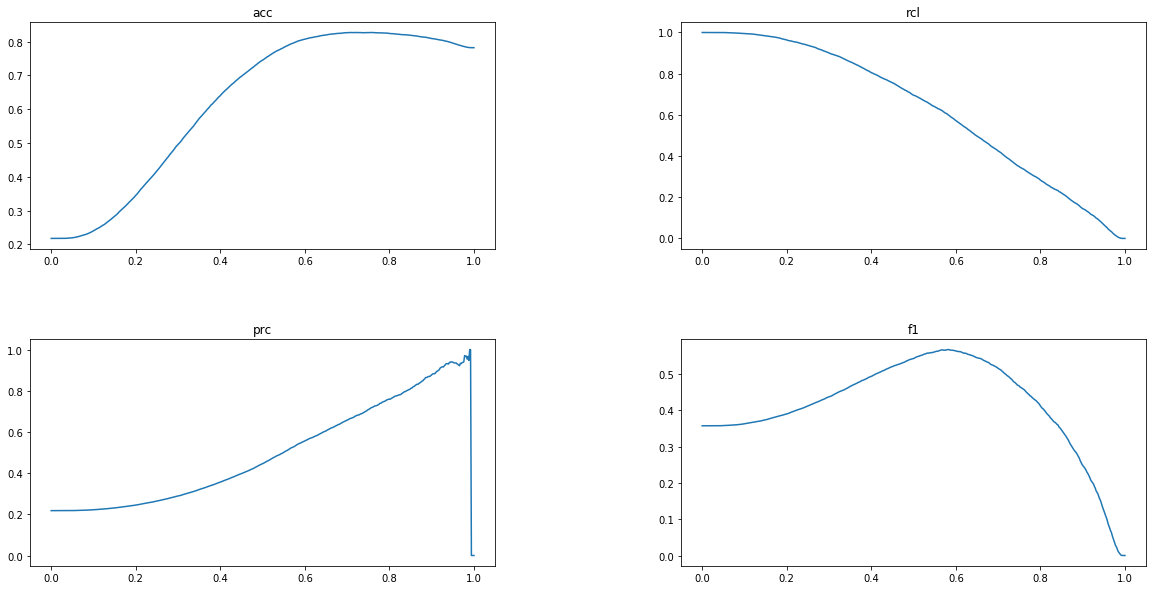

In [69]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


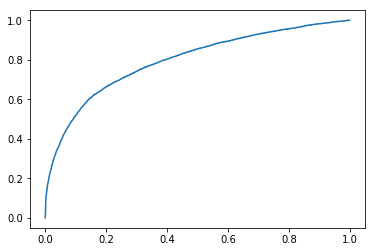

In [70]:
tpr, fpr, _ = roc_curve(y_test, probas)
plt.plot(tpr, fpr);

In [71]:
best_thres = thres[np.argmax(f1s)]
y_pred = (probas > best_thres).astype(int)
print('Best threshold: ', best_thres)
print('Acc for max f1 threshold: ', skm.accuracy_score(y_test, y_pred))
print('Max acc : ', max(accs))
print('Recall : ', skm.recall_score(y_test, y_pred))
print('Precision: ', skm.precision_score(y_test, y_pred))

Best threshold:  0.5811623246492985
Acc for max f1 threshold:  0.800641736887876
Max acc :  0.8270609050289381
Recall :  0.6014313239746766
Precision:  0.5380448165476484


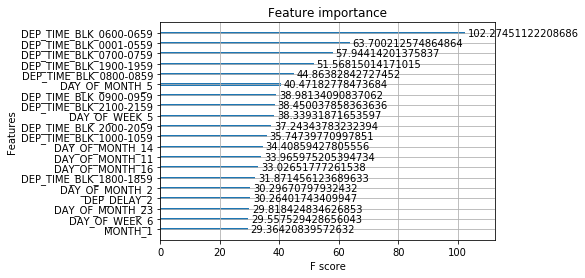

In [72]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain');